In [1]:
import sys
sys.path.insert(0, '../src/')

import abc
import numpy as np
import torch

from net.net import *

import matplotlib.pyplot as plt
%matplotlib inline

from netgan import netgan

dtype = torch.float32
device = 'cpu'

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/holgerizor/anaconda3/envs/ne

In [2]:
def draw_ground_truth(p_stars, samples_per_class):
    assert p_stars.ndim == 2
    classes_in, classes_out = p_stars.shape
    X = np.ndarray([classes_in, samples_per_class], dtype=np.int)
    Y = np.ndarray([classes_in, samples_per_class], dtype=np.int)
    for class_in in range(classes_in):
        X[class_in] = class_in * np.ones([samples_per_class])
        Y[class_in] = np.argmax(np.random.multinomial(n=1, pvals=p_stars[class_in],
                                                      size=[samples_per_class]),
                                axis=-1)
    return np.eye(classes_out)[X.reshape([-1])], Y.reshape([-1])

In [3]:
n_nodes = 20
"""
p_stars=np.array([[0.1, 0.1, 0.2, 0.2, 0.4],
                  [0.5, 0.2, 0.1, 0.1, 0.1],
                  [0.0, 0.3, 0.3, 0.3, 0.1],
                  [0.2, 0.2, 0.2, 0.2, 0.2],
                  [0.1, 0.0, 0.6, 0.0, 0.3]])
"""
p_stars = np.random.dirichlet(alpha=0.2*np.ones(n_nodes), size=n_nodes)

X, Y = draw_ground_truth(p_stars=p_stars,
                         samples_per_class=10000)

In [4]:
amounts = X.T @ np.eye(n_nodes)[Y]
normalized = amounts/amounts.sum(axis=-1).reshape((n_nodes,1))

In [5]:
class Logger(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def log(self, step, loss):
        pass
    
class BasicPrintLogger(Logger):
    def __init__(self, print_every=100):
        self.print_every = print_every
    
    def log(self, step, loss, x, logits, labels):
        if step % self.print_every == self.print_every-1:
                print(f'Step: {step}, Loss: {loss:.5f}')

In [6]:
class Net(object):
    def __init__(self, N, H, loss_fn=torch.nn.functional.cross_entropy, logger=None):
        self.loss_fn = loss_fn
        self.logger = logger
        self._optimizer = None
        self.w_down = torch.tensor(0.1 * torch.randn(N, H, device=device, dtype=dtype), requires_grad=True)
        self.w_up =  torch.tensor(0.1 * torch.randn(H, N, device=device, dtype=dtype), requires_grad=True)
              
    def __call__(self, x):
        x = torch.tensor(x, dtype=dtype)
        return torch.nn.functional.softmax(self.predict_logits(x),
                                           dim=-1).detach().numpy()
    
    def predict_logits(self, x):
        return (x @ self.w_down) @ self.w_up
    
    def _train_step(self, x, labels):
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, labels)
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        return logits, loss.item()
        
    def train(self, x, labels, steps, optimizer_fn, optimizer_args):
        x = torch.tensor(x, dtype=dtype)
        labels = torch.tensor(labels, dtype=torch.int64)
        self._optimizer = optimizer_fn([self.w_down, self.w_up] ,**optimizer_args)
        for step in range(steps):
            logits, loss = self._train_step(x, labels)
            if self.logger:
                self.logger.log(step, loss, x, logits, labels)
                
    def train_generator(self, generator, steps, optimizer_fn, optimizer_args):
        self._optimizer = optimizer_fn([self.w_down, self.w_up] ,**optimizer_args)
        for step in range(steps):
            x, labels = next(generator)
            logits, loss = self._train_step(x, labels)
            if self.logger:
                self.logger.log(step, loss, x, logits, labels)

In [3]:
model = Net(N=n_nodes, H=5, loss_fn=torch.nn.CrossEntropyLoss(), logger=BasicPrintLogger(print_every=100))

NameError: name 'n_nodes' is not defined

net.net.Net

In [8]:
model.w_down @ model.w_up

tensor([[ 6.7110e-04,  3.9167e-03,  1.0348e-03,  2.0983e-03, -3.7287e-03,
          1.2352e-03,  4.6427e-03,  7.5704e-03,  1.9505e-03,  4.4851e-03,
         -1.0603e-02,  3.5484e-03, -4.1915e-03,  1.5552e-02,  7.9632e-03,
          1.0556e-02,  8.6400e-03, -4.4887e-03, -9.9381e-03, -4.3090e-03],
        [-2.7796e-02, -2.1374e-03,  1.1913e-02, -2.2807e-05, -6.3665e-03,
         -2.6748e-03, -1.1650e-03,  1.6857e-02, -1.2133e-02,  1.7140e-02,
         -1.3890e-02, -2.4740e-02,  9.3011e-03, -1.9735e-02,  1.7850e-02,
          7.0608e-03,  2.9447e-02, -3.5309e-02, -7.1110e-03, -4.6917e-04],
        [ 2.5697e-02,  5.9656e-03, -3.3157e-02,  3.8982e-03,  2.1440e-02,
          1.4393e-02,  1.0008e-02, -1.5717e-02,  1.4459e-02, -6.0308e-03,
          4.8090e-03,  5.5262e-02, -3.4271e-02,  3.2733e-02, -2.9167e-02,
          1.5600e-03, -2.6403e-02,  2.3320e-02, -1.8319e-03, -1.2062e-02],
        [ 1.5873e-02, -2.9874e-03,  2.1740e-02,  2.5282e-03, -9.3776e-04,
         -5.9209e-03, -7.3181e-03, 

In [11]:
model.train(x=X,
            labels=Y,
            steps=5000,
            optimizer_fn=torch.optim.SGD,
            optimizer_args={'lr': 0.1})

Step: 99, Loss: 2.97719
Step: 199, Loss: 2.95484
Step: 299, Loss: 2.91424
Step: 399, Loss: 2.83856
Step: 499, Loss: 2.71799
Step: 599, Loss: 2.56096
Step: 699, Loss: 2.42010
Step: 799, Loss: 2.31719
Step: 899, Loss: 2.24325
Step: 999, Loss: 2.18678
Step: 1099, Loss: 2.14320
Step: 1199, Loss: 2.10878
Step: 1299, Loss: 2.08054
Step: 1399, Loss: 2.05660
Step: 1499, Loss: 2.03680
Step: 1599, Loss: 2.01892
Step: 1699, Loss: 2.00539
Step: 1799, Loss: 1.99155
Step: 1899, Loss: 1.98227
Step: 1999, Loss: 1.97185
Step: 2099, Loss: 1.96348
Step: 2199, Loss: 1.95688
Step: 2299, Loss: 1.95025
Step: 2399, Loss: 1.94426
Step: 2499, Loss: 1.93764
Step: 2599, Loss: 1.93286
Step: 2699, Loss: 1.92787
Step: 2799, Loss: 1.92556
Step: 2899, Loss: 1.92206
Step: 2999, Loss: 1.91959
Step: 3099, Loss: 1.91540
Step: 3199, Loss: 1.91347
Step: 3299, Loss: 1.91136
Step: 3399, Loss: 1.91001
Step: 3499, Loss: 1.90907
Step: 3599, Loss: 1.90750
Step: 3699, Loss: 1.90547
Step: 3799, Loss: 1.90399
Step: 3899, Loss: 1.902

In [4]:
4.78+6.62+1.70

13.1

In [12]:
np.linalg.matrix_rank(model(np.eye(n_nodes)))

20

([array([14.,  4.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([9., 5., 2., 3., 1., 0., 0., 0., 0., 0.]),
  array([9., 6., 3., 1., 0., 0., 1., 0., 0., 0.]),
  array([10.,  6.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([9., 5., 2., 3., 1., 0., 0., 0., 0., 0.]),
  array([11.,  1.,  4.,  2.,  0.,  0.,  0.,  1.,  1.,  0.]),
  array([14.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
  array([12.,  5.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.]),
  array([11.,  4.,  1.,  3.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([11.,  6.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.]),
  array([14.,  2.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
  array([13.,  3.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.]),
  array([10.,  4.,  2.,  2.,  1.,  0.,  0.,  1.,  0.,  0.]),
  array([10.,  5.,  1.,  3.,  0.,  1.,  0.,  0.,  0.,  0.]),
  array([8., 6., 2., 4., 0., 0., 0., 0., 0., 0.]),
  array([11.,  2.,  4.,  2.,  1.,  0.,  0.,  0.,  0.,  0.]),
  array([12.,  3.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.]),
  a

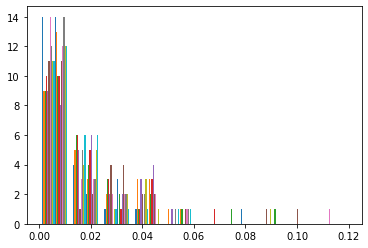

In [15]:
plt.hist(np.abs((model(np.eye(n_nodes))-p_stars)))

In [16]:
np.linalg.norm(normalized - p_stars)

0.037179497211325865

In [17]:
np.linalg.norm(model(np.eye(n_nodes)) - p_stars)

0.4654196748812593